### ***Theory of random forest***

As described in DT notebook, DT are subject to high overfitting because they have low bias and high variance errors. The first is high if we have made a lot of assumptions about the target function, so if our modelling function is not flexible. The second, instead, refers to the variability of a target function w.r.t. different training samples: models with high variance will change a lot when small modifications of the training dataset are made. The idea used by RF to overcome this limitations is to build multiple trees and average their predictions for regression or use majority voting (or confidence averaging) for classification. Each tree is built using a different dataset and a random subset of features.

To reduce the variance error, RF employs *bootstrap aggregation* (or *bagging*). Among the different techniques used for it, the one that will be used in this notebook was proposed by the inventors of RF Leo Breiman and Adele Cutler. Given a dataset $D=\{(X_1, y_1), \dots, (X_N, y_N)\}$ where $X_i$ are the features and $y_i$ the labels, we generate $B$ bootstrapped samples $D_1, \dots, D_B$ by sampling with replacement $N$ tuples from $D$. Because replacement is allowed there might be some duplicate elements in $D_k$. Then, a decision tree $T_i$ is trained using $D_i$. Without bootstrapping, all the trees would be highly correlated, i.e. if $T_i$ predicts label $\tilde y$, there's a high chance that also $T_k$ will predict $\tilde y$: consequently, if one overfits, the others will overfit either. Note that this allows us to parallelize the training process: different machines will train one (or several) model.

Moreover, each $T_i$ is built considering only a random subset of $|F_i|=m$ features among the total $|F|=d$ features at eah best split call (see `DecisionTree.find_best_split(...)`): if we used the entire features vector, even with bootstrapping, there would be an high chance to keep using the mostly dominant features, not reducing correlation. Typically, $m=\sqrt{d}$ for classification and $m=\frac13d$ for regression. 

When it comes to make a prediction for a classification task, the typical idea is to use *majority voting*:
$$\tilde y = \arg \max_{k}\,\,\sum_{i = 1}^{B}\mathbb{I}\{T_i(x) = k\}$$

where $k$ is a label, $\mathbb{I}\{...\}$ is the indicator function and $T_i(x)$ is the prediction of the $i\text{-th}$ tree. Another way is to exploit the probabilities outputted by each tree. For a specific sample $x$, the confidence of the RF in the prediction $k$ is given by the average of the confidences of the trees:
$$P\{k \text{ for sample } x\} = \frac{1}{B}\sum_{i=1}^{B}P\{k \text{ assigned to } x \text{ by tree } T_i\}$$

Consequently, the predicted class is the one with largest probability:
$$\tilde y = \arg \max_{k}\,\,\frac{1}{B}\sum_{i=1}^{B}P\{k \text{ assigned to } x \text{ by tree } T_i\}$$

Both of this methods are supported by our implementation. In general, the latter approach is preferred when it's required to plot ROC curves since it outputs continuos probabilities, rather than agreement fractions (nevertheless, also the first can be used). Also, the second is more calibrated because it reflects the true probabilities on building DT in the RF; since in our DT the `Node.value` of a leaf is given by the classes with largest number of samples belonging to it (so, the one with highest probability), both methods will produce the same results in terms of accuracy, precision, recall and F1. 

Vice versa, for a regression task (not necessary in this notebook, but reported for the sake of completeness):
$$\tilde y = \frac1B\sum_{i=1}^{B}T_i(x)$$

### ***Model definition***

In [26]:
import numpy as np
from tqdm import tqdm

import sys
sys.path.append("..")
from utils.models.DecisionTree import DecisionTree

In [27]:
class RandomForest:
    def __init__(self, 
                 n_trees = 10,
                 criterion = "gini", 
                 max_depth = None, 
                 min_samples_split = 2, 
                 min_samples_leaf = 1, 
                 min_impurity_decrease = 0.0,
                 max_thresholds = 1,
                 max_features = "sqrt", #As explained in the theory part, for classification tasks, sqrt(n_features) is typically used.
                                        #We choose to not pass directly this value to the DT because in some contexts, user might want to change it;
                                        #see for more details methods "build_tree(...)" and "find_best_split(...)" of DT.
                 random_state = 0):
        
        """
            Initializes both random forest' and decision tree' parameters.
            
            Args:
                - Parameters of RF:
                    n_trees (int): number of trees to be built
                    random_state (int): random seed.
                
                - Parameters of DT to be built: 
                    criterion (str): the function to measure the quality of a split ("gini" or "entropy").
                    max_depth (int): the maximum depth of the tree.
                    min_samples_split (int): the minimum number of samples required to split an internal node.
                    min_samples_leaf (int): the minimum number of samples required to be at a leaf node.
                    min_impurity_decrease (float): the minimum impurity decrease required to split a node.
                    max_thresholds (int): the maximum number of thresholds to use during best split search.
                    max_features (str / float): the maximum number of features to choose from in the given ones: 
                                                    - if "sqrt", then int(sqrt(n_features)); 
                                                    - if "log2", then int(log2(n_features)):
                                                    - if float, then int(n_features * max_features);
                                                    - if int, then max_features;
                                                    - if None, all features
                    random_state (int): random seed.
        """
        
        self.n_trees = n_trees

        #When the training process is complete, all the DecisionTree objects in this list will be trained
        self.trees = [DecisionTree(criterion = criterion,
                                   max_depth = max_depth,
                                   min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf,
                                   min_impurity_decrease = min_impurity_decrease,
                                   max_thresholds = max_thresholds,
                                   max_features = max_features,
                                   random_state = random_state)
                     for _ in range(self.n_trees)]

        self.random_state = random_state

    def fit(self, X, y):
        """
            Fit a RF model with the specified parameters to the data. 

            Args:
                X (np.ndarray): the matrix containing the features (sample on the rows);
                y (np.ndarray): the vector containing the labels.
        """
 
        for i in tqdm(range(self.n_trees), desc = "Training of RF"):
            #For each subtree that we have to build, we generate a bootstrapped dataset
            bs_ids = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = True)
            X_bs = X[bs_ids]
            y_bs = y[bs_ids]

            #Then, we train the DT on it
            self.trees[i].fit(X_bs, y_bs)

    def predict(self, X, type = "prob"):
        """
            This method predicts the labels of a given set of samples.

            Args:
                X (np.ndarray): the matrix containing the samples to be classified (samples on rows).
                type (str): if "prob", predicted labels and average probabilities for them are returned,
                            if "voting", predicted labels and voting fraction are returned.
 
            Returns:
                labels (np.ndarray): the predicted label of each sample in X.
                scores (np.ndarray): the score associated to each prediction (see "type" attribute).
        """

        #As defined in the theory part, we collect the predictions and probabilities of each tree.
        pred_labels, pred_probs = zip(*[t.predict(X) for t in self.trees])

        #Note: this will a matrix of shape n_trees x n_samples because the prediction is a number 
        pred_labels = np.array(pred_labels)

        #Note: this will be a tensor of shape n_trees x n_samples x n_classes because each tree is outputting a vector of probabilities
        pred_probs = np.array(pred_probs)

        if type == "prob":          
            #First, compute the average probability across all trees: we are working row by row (each row is n_samples x n_classes),
            #taking the average of each array of probabilities [... n_classes ...]. The resulting matrix will be n_samples x n_classes
            avg_probs = np.mean(pred_probs, axis = 0)
            
            #Each column of "avg_probs" contains the average probabilities for a specific class; thus, to have the label of each sample, we have to take the 
            #argmax over all the columns argmax([... n_classes ...]).
            labels = np.argmax(avg_probs, axis = 1)
    
            return labels, avg_probs
        elif type == "voting":
            #For each sample, voting fractions are represented by an array of length n_classes and we have n_samples samples, so
            #the matrix has shape (n_samples, n_classes)
            voting_fractions = np.zeros((X.shape[0], self.trees[0].num_classes))  

            #Each row of pred_labels contains the labels assigned to all the samples by a specific tree, so to compute the voting fraction, we need to 
            #count the frequencies of each label in a certain column and then normalize them
            for sample_idx in range(X.shape[0]):
            
                #Count the number of trees voting for each class for the current sample: min_length = num_classes is used so that even if all 
                #trees agree on a certain label the resulting voting_fractions array will have length n_classes ([0, 0, ..., 1, ..., 0, 0])
                class_counts = np.bincount(pred_labels[:, sample_idx], minlength = self.trees[0].num_classes)
                
                #Then, normalize to obtain a value in [0, 1]
                voting_fractions[sample_idx] = class_counts / self.n_trees

            #The predicted label is the one with the largest voting fraction
            labels = np.argmax(voting_fractions, axis = 1)

            return labels, voting_fractions
        else:
            raise ValueError(f"Parameter 'type' should be either 'prob' or 'voting', got {type}")


### ***Usage of the model***

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import sys
sys.path.append("..")

from utils.preprocessing import undersample, fit_resample

import utils.model_evaluation as me
import matplotlib.pyplot as plt

In [29]:
#Load the dataset
init_data = pd.read_csv("../creditcard_2021.csv")
data = init_data[me.feature_vectors["v5"] + ["Class"]]

#"Class" column is the target variable, so we remove it from the feature matrix and store it in the variable y
X = data.drop(columns = ["Class"])
y = data["Class"]

X = np.array(X)
y = np.array(y)

In [30]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [31]:
#Note: in contrast with what have been done for DT, here we apply SMOTE because we have observed experimentally that it increases the recall with slight decrease of the precision on the testing set
X_smote = fit_resample(X_train[y_train == 1], 2500, 10)

X_train = np.vstack((X_train, X_smote))
y_train = np.hstack((y_train, [1] * 2500))

In [40]:
rf = RandomForest(n_trees = 25,
                  criterion = "entropy", 
                  max_depth = 15, 
                  min_samples_split = 2, 
                  min_samples_leaf = 1, 
                  min_impurity_decrease = 1e-7, #Important parameter: small changes can lead to big differences in the tree and its performance
                  max_thresholds = 75, 
                  random_state = 0)

In [41]:
#Once defined, we can train the model
rf.fit(X_train, y_train)

Training of RF: 100%|██████████| 25/25 [03:39<00:00,  8.80s/it]


In [42]:
#Once trained, we can make predictions with type = "prob"
y_pred, votes = rf.predict(X_test, type = "prob")
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

In [43]:
votes

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       ...,
       [9.99948254e-01, 5.17464424e-05],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]], shape=(85443, 2))

Precision: 0.9291338582677166
Recall: 0.8027210884353742
F1 Score: 0.8613138686131387
Accuracy: 0.9995552590615966
AUC Score: 0.9637972591963067


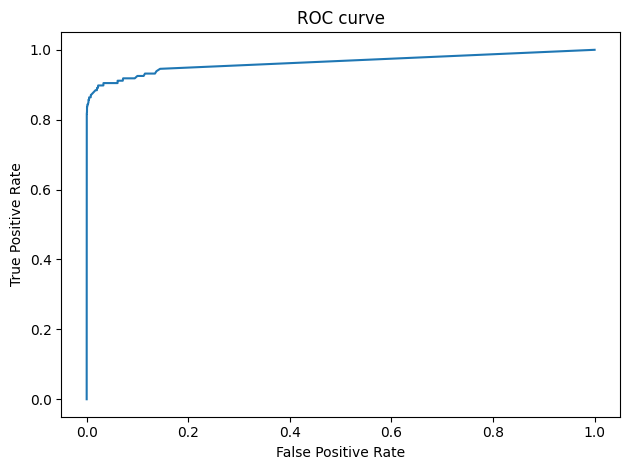

In [44]:
metrics = me.compute_metrics(y_test, y_pred)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

fpr, tpr, auc = me.compute_roc_auc(y_test, votes[:, 1])
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [45]:
#Or we can make predictions with type = "voting"
y_pred, votes = rf.predict(X_test, type = "voting")
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

In [46]:
votes

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(85443, 2))

Precision: 0.9291338582677166
Recall: 0.8027210884353742
F1 Score: 0.8613138686131387
Accuracy: 0.9995552590615966
AUC Score: 0.9407440452264192


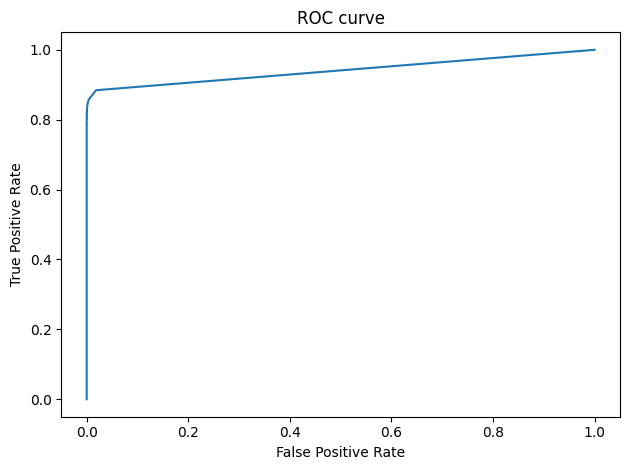

In [47]:
metrics = me.compute_metrics(y_test, y_pred)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

fpr, tpr, auc = me.compute_roc_auc(y_test, votes[:, 1])
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [25]:
params = {
    "n_trees" : 25,
    "criterion" : "entropy", 
    "max_depth" : 15, 
    "min_samples_split" : 5, 
    "min_samples_leaf" : 2, 
    "min_impurity_decrease" : 1e-5, 
    "max_thresholds" : 75, 
    "random_state" : 0
}

metrics_training = pd.DataFrame()
metrics_testing = pd.DataFrame()

roc_auc_training = {}
roc_auc_testing = {}

X_2 = init_data.drop(columns = ["Class"])
y_2 = data["Class"]

X_2 = np.array(X_2)
y_2 = np.array(y_2)

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size = 0.3, random_state = 0)

X_smote = fit_resample(X_train[y_train == 1], 2500, 10)
X_train = np.vstack((X_train, X_smote))
y_train = np.hstack((y_train, [1] * 2500))

for key, value in me.feature_vectors.items():
    print(f"Current feature vector: {value}")

    X_tr = X_train[:, np.array(me.feature_masks[key]).astype(bool)]
    X_te = X_test[:, np.array(me.feature_masks[key]).astype(bool)]

    rf = RandomForest(**params)

    rf.fit(X_tr, y_train)
    y_pred, y_prob = rf.predict(X_tr, type = "prob")

    metrics_training = me.compute_metrics(y_train, y_pred, metrics_df = metrics_training, dataset_label = key)
    roc_auc_training[key] = me.compute_roc_auc(y_train, y_prob[:, 1])

    y_pred, y_prob = rf.predict(X_te, type = "prob")
    
    metrics_testing = me.compute_metrics(y_test, y_pred, metrics_df = metrics_testing, dataset_label = key)
    roc_auc_testing[key] = me.compute_roc_auc(y_test, y_prob[:, 1])
    
    print("")

Current feature vector: ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount']


Training of RF: 100%|██████████| 25/25 [04:10<00:00, 10.02s/it]



Current feature vector: ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [03:35<00:00,  8.61s/it]



Current feature vector: ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount']


Training of RF: 100%|██████████| 25/25 [03:18<00:00,  7.93s/it]



Current feature vector: ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [03:19<00:00,  7.97s/it]



Current feature vector: ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [02:54<00:00,  7.00s/it]



Current feature vector: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [04:54<00:00, 11.79s/it]



Current feature vector: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [04:40<00:00, 11.23s/it]


In [26]:
#Metrics for training
metrics_training

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,2723,199017,2,122,0.999386,0.957118,0.999266,0.977738,201864,2845
1,v2,2576,199011,8,269,0.998628,0.905448,0.996904,0.948978,201864,2845
2,v3,2663,199012,7,182,0.999064,0.936028,0.997378,0.965730,201864,2845
3,v4,2695,199010,9,150,0.999212,0.947276,0.996672,0.971346,201864,2845
4,v5,2737,199014,5,108,0.999440,0.962039,0.998177,0.979774,201864,2845
5,v6,2790,199017,2,55,0.999718,0.980668,0.999284,0.989888,201864,2845
6,v7,2795,199013,6,50,0.999723,0.982425,0.997858,0.990081,201864,2845


In [27]:
#Metrics for testing
metrics_testing

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,119,85285,11,28,0.999544,0.809524,0.915385,0.859206,85443,147
1,v2,115,85279,17,32,0.999427,0.782313,0.871212,0.824373,85443,147
2,v3,117,85280,16,30,0.999462,0.795918,0.879699,0.835714,85443,147
3,v4,118,85280,16,29,0.999473,0.802721,0.880597,0.839858,85443,147
4,v5,119,85286,10,28,0.999555,0.809524,0.922481,0.862319,85443,147
5,v6,121,85282,14,26,0.999532,0.823129,0.896296,0.858156,85443,147
6,v7,119,85281,15,28,0.999497,0.809524,0.888060,0.846975,85443,147


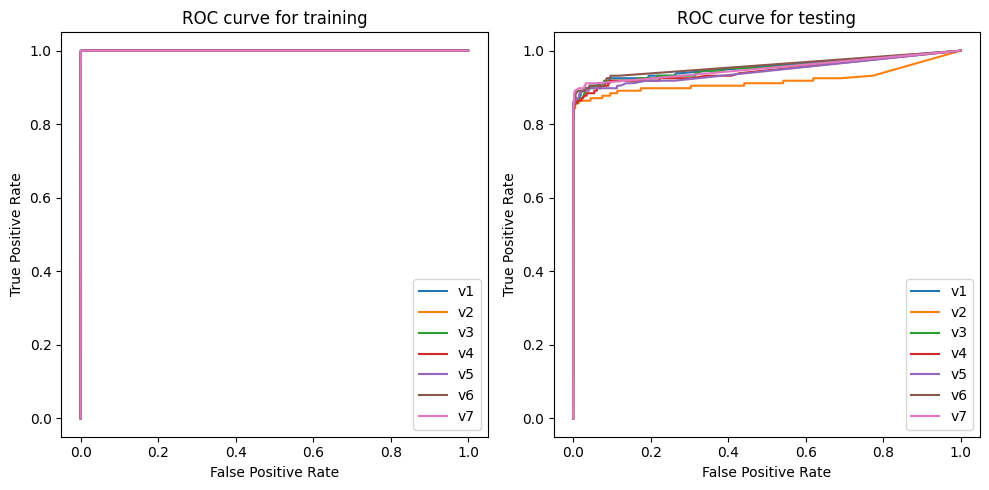

Training AUC:
v1 -> 0.9999957418554531
v2 -> 0.9999691191798408
v3 -> 0.999992089494224
v4 -> 0.9999916956467609
v5 -> 0.9999969419422302
v6 -> 0.9999988361189314
v7 -> 0.9999984731787802

Testing AUC:
v1 -> 0.955074055039386
v2 -> 0.9180580997170956
v3 -> 0.9525930588892844
v4 -> 0.9464364272251765
v5 -> 0.9449522000696733
v6 -> 0.9589443707514894
v7 -> 0.9523325016556989


In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training.keys():
    axs[0].plot(roc_auc_training[i][0], roc_auc_training[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing.keys():
    axs[1].plot(roc_auc_testing[i][0], roc_auc_testing[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training.items():
    print(f"{i} -> {auc[2]}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing.items():
    print(f"{i} -> {auc[2]}")

In [6]:
#One thing that we can try to do is undersampling:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, y_train = undersample(X_train, y_train, 0, 1 - (sum(y_train) * 300.0 / X_train.shape[0]))

In [7]:
rf = RandomForest(n_trees = 20,
                  criterion = "gini", 
                  max_depth = 10, 
                  min_samples_split = 2, 
                  min_samples_leaf = 1, 
                  min_impurity_decrease = 0.0, #Important parameter: small changes can lead to big differences in the tree and its performance (1e-5)
                  max_thresholds = 20, 
                  random_state = 0)

In [8]:
#Once defined, we can train the model
rf.fit(X_train, y_train)

Training of RF: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


In [9]:
#Once trained, we can make predictions
y_pred, votes = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

Precision: 0.9487179487179487
Recall: 0.7551020408163265
F1 Score: 0.8409090909090908
Accuracy: 0.9995084442259752
AUC Score: 0.9582330423259156


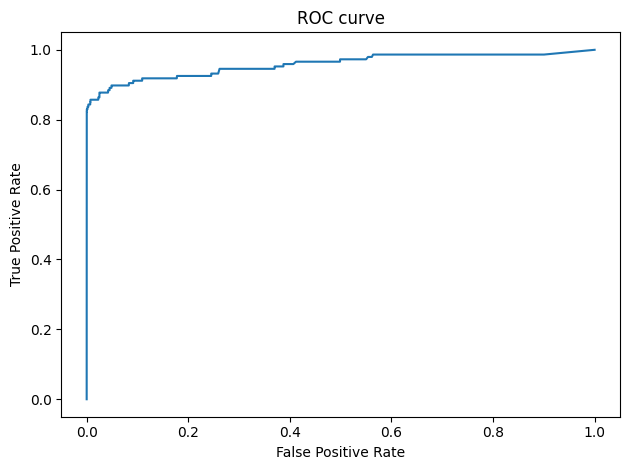

In [10]:
metrics = me.compute_metrics(y_test, y_pred)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

fpr, tpr, auc = me.compute_roc_auc(y_test, votes[:, 1])
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [11]:
params = {
    "n_trees" : 20,
    "criterion" : "gini", 
    "max_depth" : 10, 
    "min_samples_split" : 2, 
    "min_samples_leaf" : 1, 
    "min_impurity_decrease" : 0.0, 
    "max_thresholds" : 20, 
    "random_state" : 0
}

metrics_training_2 = pd.DataFrame()
metrics_testing_2 = pd.DataFrame()

roc_auc_training_2 = {}
roc_auc_testing_2 = {}

X_2 = init_data.drop(columns = ["Class"])
y_2 = data["Class"]

X_2 = np.array(X_2)
y_2 = np.array(y_2)

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size = 0.3, random_state = 0)

#As done for the previous case, we undersample the dataset
X_train, y_train = undersample(X_train, y_train, 0, 1 - (sum(y_train) * 300.0 / X_train.shape[0]))

for key, value in me.feature_vectors.items():
    print(f"Current feature vector: {value}")

    X_tr = X_train[:, np.array(me.feature_masks[key]).astype(bool)]
    X_te = X_test[:, np.array(me.feature_masks[key]).astype(bool)]

    rf = RandomForest(**params)

    rf.fit(X_tr, y_train)
    y_pred, y_prob = rf.predict(X_tr, type = "prob")

    metrics_training_2 = me.compute_metrics(y_train, y_pred, metrics_df = metrics_training_2, dataset_label = key)
    roc_auc_training_2[key] = me.compute_roc_auc(y_train, y_prob[:, 1])

    y_pred, y_prob = rf.predict(X_te, type = "prob")
    
    metrics_testing_2 = me.compute_metrics(y_test, y_pred, metrics_df = metrics_testing_2, dataset_label = key)
    roc_auc_testing_2[key] = me.compute_roc_auc(y_test, y_prob[:, 1])
    
    print("")

Current feature vector: ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]



Current feature vector: ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:20<00:00,  1.00s/it]



Current feature vector: ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]



Current feature vector: ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]



Current feature vector: ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]



Current feature vector: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]



Current feature vector: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


In [30]:
#Metrics for training
metrics_training_2

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,163,103315,0,21,0.999797,0.885870,1.000000,0.939481,103499,184
1,v2,161,103314,1,23,0.999768,0.875000,0.993827,0.930636,103499,184
2,v3,162,103315,0,22,0.999787,0.880435,1.000000,0.936416,103499,184
3,v4,161,103315,0,23,0.999778,0.875000,1.000000,0.933333,103499,184
4,v5,165,103315,0,19,0.999816,0.896739,1.000000,0.945559,103499,184
5,v6,162,103315,0,22,0.999787,0.880435,1.000000,0.936416,103499,184
6,v7,165,103315,0,19,0.999816,0.896739,1.000000,0.945559,103499,184


In [31]:
#Metrics for testing
metrics_testing_2

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,103,85292,4,44,0.999438,0.700680,0.962617,0.811024,85443,147
1,v2,95,85285,11,52,0.999263,0.646259,0.896226,0.750988,85443,147
2,v3,102,85286,10,45,0.999356,0.693878,0.910714,0.787645,85443,147
3,v4,99,85288,8,48,0.999345,0.673469,0.925234,0.779528,85443,147
4,v5,110,85290,6,37,0.999497,0.748299,0.948276,0.836502,85443,147
5,v6,109,85289,7,38,0.999473,0.741497,0.939655,0.828897,85443,147
6,v7,106,85291,5,41,0.999462,0.721088,0.954955,0.821705,85443,147


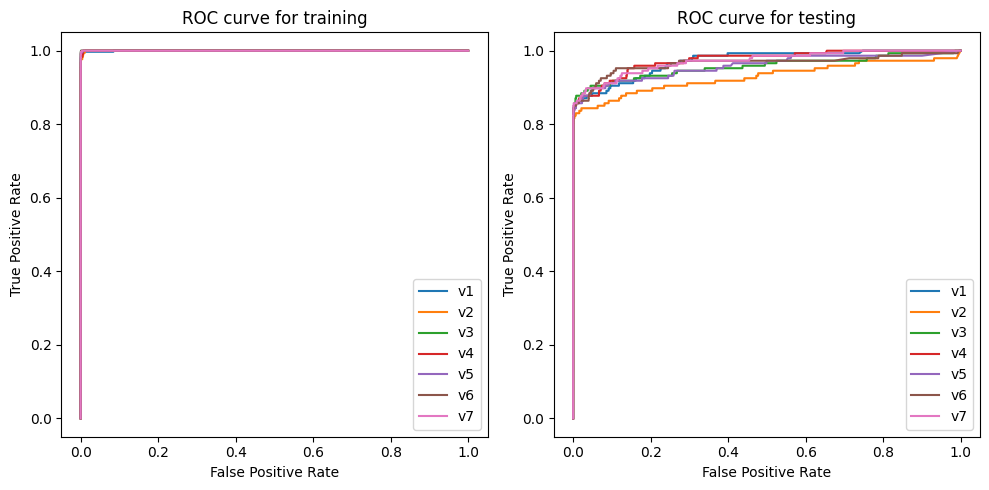

Training AUC:
v1 -> 0.9997073135622259
v2 -> 0.9998090018653124
v3 -> 0.9999866133272169
v4 -> 0.9998858352058573
v5 -> 0.999962528518444
v6 -> 0.9999855771203279
v7 -> 0.9999776515379061

Testing AUC:
v1 -> 0.9716665741517015
v2 -> 0.9285595053065308
v3 -> 0.9568448393238367
v4 -> 0.9748195399900722
v5 -> 0.9582330423259156
v6 -> 0.9660306980605033
v7 -> 0.9717761565327688


In [13]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training_2.keys():
    axs[0].plot(roc_auc_training_2[i][0], roc_auc_training_2[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing_2.keys():
    axs[1].plot(roc_auc_testing_2[i][0], roc_auc_testing_2[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training_2.items():
    print(f"{i} -> {auc[2]}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing_2.items():
    print(f"{i} -> {auc[2]}")

In [ ]:
#Another model with entropy, but a fixed number of features checked when looking for the best split
params = {
    "n_trees" : 10,
    "criterion" : "entropy", 
    "max_depth" : 15, 
    "min_samples_split" : 5, 
    "min_samples_leaf" : 2, 
    "min_impurity_decrease" : 0.0, 
    "max_thresholds" : 75, 
    "max_features" : 10,
    "random_state" : 0
}

metrics_training_3 = pd.DataFrame()
metrics_testing_3 = pd.DataFrame()

roc_auc_training_3 = {}
roc_auc_testing_3 = {}

X_3 = init_data.drop(columns = ["Class"])
y_3 = data["Class"]

X_3 = np.array(X_3)
y_3 = np.array(y_3)

X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size = 0.3, random_state = 0)

X_smote = fit_resample(X_train[y_train == 1], 2500, 5)
X_train = np.vstack((X_train, X_smote))
y_train = np.hstack((y_train, [1] * 2500))

for key, value in me.feature_vectors.items():
    print(f"Current feature vector: {value}")

    X_tr = X_train[:, np.array(me.feature_masks[key]).astype(bool)]
    X_te = X_test[:, np.array(me.feature_masks[key]).astype(bool)]

    rf = RandomForest(**params)

    rf.fit(X_tr, y_train)
    y_pred, y_prob = rf.predict(X_tr, type = "prob")

    metrics_training_3 = me.compute_metrics(y_train, y_pred, metrics_df = metrics_training_3, dataset_label = key)
    roc_auc_training_3[key] = me.compute_roc_auc(y_train, y_prob[:, 1])

    y_pred, y_prob = rf.predict(X_te, type = "prob")
    
    metrics_testing_3 = me.compute_metrics(y_test, y_pred, metrics_df = metrics_testing_3, dataset_label = key)
    roc_auc_testing_3[key] = me.compute_roc_auc(y_test, y_prob[:, 1])
    
    print("")

Current feature vector: ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount']


Training of RF: 100%|██████████| 10/10 [03:49<00:00, 22.95s/it]



Current feature vector: ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount']


Training of RF: 100%|██████████| 10/10 [03:59<00:00, 23.90s/it]



Current feature vector: ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount']


Training of RF: 100%|██████████| 10/10 [04:11<00:00, 25.17s/it]



Current feature vector: ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount']


Training of RF: 100%|██████████| 10/10 [04:04<00:00, 24.47s/it]



Current feature vector: ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 10/10 [03:29<00:00, 20.98s/it]



Current feature vector: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 10/10 [03:37<00:00, 21.77s/it]



Current feature vector: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 10/10 [03:37<00:00, 21.74s/it]


In [10]:
metrics_training_3

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,2751,199014,5,94,0.999510,0.966960,0.998186,0.982325,201864,2845
1,v2,2665,199008,11,180,0.999054,0.936731,0.995889,0.965405,201864,2845
2,v3,2733,199013,6,112,0.999415,0.960633,0.997809,0.978868,201864,2845
3,v4,2699,199014,5,146,0.999252,0.948682,0.998151,0.972788,201864,2845
4,v5,2772,199011,8,73,0.999599,0.974341,0.997122,0.985600,201864,2845
5,v6,2800,199014,5,45,0.999752,0.984183,0.998217,0.991150,201864,2845
6,v7,2798,199017,2,47,0.999757,0.983480,0.999286,0.991320,201864,2845


In [11]:
metrics_testing_3

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,117,85282,14,30,0.999485,0.795918,0.893130,0.841727,85443,147
1,v2,117,85274,22,30,0.999391,0.795918,0.841727,0.818182,85443,147
2,v3,118,85273,23,29,0.999391,0.802721,0.836879,0.819444,85443,147
3,v4,119,85278,18,28,0.999462,0.809524,0.868613,0.838028,85443,147
4,v5,120,85276,20,27,0.999450,0.816327,0.857143,0.836237,85443,147
5,v6,120,85278,18,27,0.999473,0.816327,0.869565,0.842105,85443,147
6,v7,121,85280,16,26,0.999508,0.823129,0.883212,0.852113,85443,147


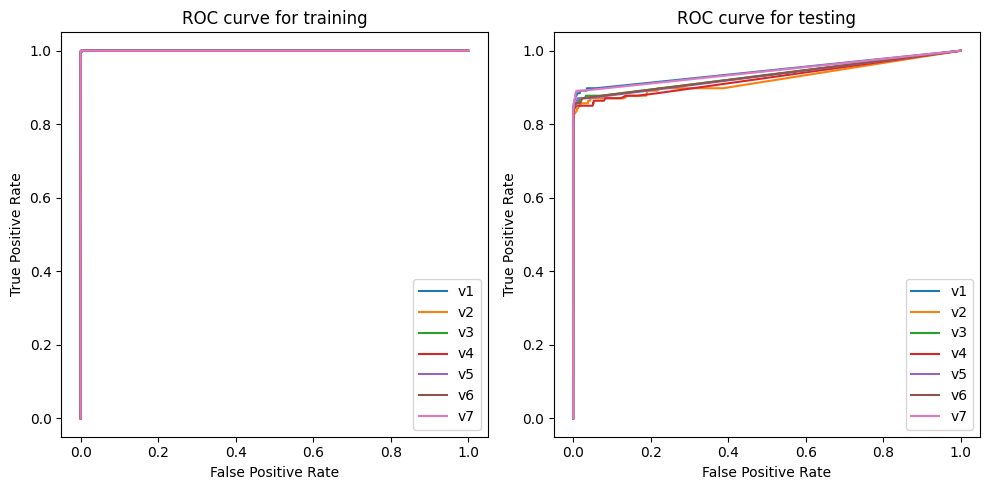

Training AUC:
v1 -> 0.9999964836309444
v2 -> 0.9999745809434291
v3 -> 0.9999915923280315
v4 -> 0.9999799155455046
v5 -> 0.9999965260181154
v6 -> 0.999998353964862
v7 -> 0.9999978462018768

Testing AUC:
v1 -> 0.9453591462846629
v2 -> 0.9232469929446174
v3 -> 0.9338543919725083
v4 -> 0.9260769539479644
v5 -> 0.9325762498771785
v6 -> 0.9335027952280143
v7 -> 0.9440583938508811


In [12]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training_3.keys():
    axs[0].plot(roc_auc_training_3[i][0], roc_auc_training_3[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing_3.keys():
    axs[1].plot(roc_auc_testing_3[i][0], roc_auc_testing_3[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training_3.items():
    print(f"{i} -> {auc[2]}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing_3.items():
    print(f"{i} -> {auc[2]}")